In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import torch
import torch.nn.functional as F
import functorch
from functorch import jacrev
from functorch import make_functional, vmap, grad

In [4]:
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
    def forward(self,x):
        return self.backbone(x)**2

In [3]:
import torch
from functorch import make_functional, vmap, grad
model= MyModel(3, 4)
x    = torch.randn(7, 3)
func_model, params = make_functional(model)
w    = params[0]
batch_J= vmap(jacrev(func_model, argnums=1), (None, 0))(params, x)
batch_H= jacrev(vmap(jacrev(func_model, argnums=1), (None, 0)), argnums=0)(params, x)

In [4]:
batch_J.shape

torch.Size([7, 4, 3])

这里设定
$$
Y=(W^TX)^2 则 Y_{j}=(\sum W_{jk}X_k)^2
$$

那么 
$$
\frac{dY_{j}}{dX_{\alpha}}=2 (\sum W_{jk}X_k) (\sum W_{jk}\delta_{\alpha k})=2 (\sum W_{jk}X_k) W_{j\alpha}
$$

首先来看 Jacobian 

In [6]:
y1 = torch.einsum('ij,bj->bi',w,x)
yx = 2*torch.einsum('bi,ik->bik',y1,w)
print(torch.allclose(yx,batch_J))

True


再来看 Hessian

那么 
$$
\begin{align}
\frac{d^2Y_{j}}{dW_{\beta\gamma}dX_{\alpha}}
&=\frac{d}{dW_{\beta\gamma}}\frac{dY_{j}}{dX_{\alpha}}=2 \frac{d}{dW_{\beta\gamma}}(\sum_k W_{jk}X_k) W_{j\alpha}\\
&=2 (\sum_k \delta_{jk}^{\beta\gamma} X_k)  W_{j\alpha} + 2 (\sum_k W_{jk}X_k)\delta_{j\alpha}^{\beta\gamma}\\
&=2 (\delta_{j}^{\beta} X_{\gamma})W_{j\alpha} +2 (\sum_k W_{jk}X_k)\delta_{j}^{\beta}\delta_{\alpha}^{\gamma}
\end{align}
$$

In [5]:
dta1 = torch.eye(w.shape[0],w.shape[0])
dta2 = torch.eye(w.shape[1],x.shape[1])

h=2*torch.einsum('bj,Bg,ja   ->Bjabg',dta1,x,w) \
 +2*torch.einsum('jk,Bk,bj,ga->Bjabg',w,x,dta1,dta2)
print(torch.allclose(h,batch_H[0]))

True


#### 我们也可以直接来计算正则项的导数
$$
P^{\gamma}=< y^\gamma,t^\gamma >+\lambda_1 (\sum_\alpha J_\alpha^{\gamma}-1)^2+\lambda_2 [\sum_\alpha (J_\alpha^{\gamma})^2-1]^2
$$

如果我们的函数是 $Y = (WX)**2$ 即 $y_j = (\sum_k W_{jk}X_k)^2$ 那么

$$
J_\alpha^\gamma = \frac{dY_{\gamma}}{dX_{\alpha}}=2 (\sum_k W_{\gamma k}X_k) (\sum_k W_{\gamma k}\delta_{\alpha k})=2 (\sum_k W_{\gamma k}X_k) W_{\gamma\alpha}
$$

那么我们可以显式的得到 
$$
\sum_\alpha J_\alpha^{\gamma} = \sum_\alpha 2 (\sum_k W_{\gamma k}X_k) W_{j\alpha} = 2 (\sum_k W_{\gamma k}X_k) \sum_\alpha W_{\gamma\alpha}
$$

我们的 L1 约束是对每一个上标 $(\sum_\alpha J_\alpha^{\gamma}-1)^2$ 都极小, 在这个 toy 模型里面, $\gamma$ 只是 $W$ 的某一行, 所以我们现在去掉上标 $W_{\gamma k}\rightarrow w_k$, 得到
$$
P(w) = <w|x><w|\mathbf{1}>
$$
再给定 |x> 的情况下, 我们要观察 $P(w) =1$ 这个解是否存在, 以及他是否是 $(P(w)-1)^2$ 的极小值解.

注意 |x> 是一个 batch tensor, 意思是我们会要求所有的 x 都要满足 $P(w;x) =1$

我们不妨假设 $\sum_\alpha w_{\alpha} = 1/\Lambda$ 为一个常数. 那么就得到方程组(n个未知数,一个方程,必有解, 如果有B个 Batch 那么总的方程数是B, 所以最后存在解的条件就是参数量要大于数据量)
$$
w_1+w_2+\dots+w_n = 1/\Lambda\\
w_1x_1+w_2x_2+\dots+w_nx_n = \Lambda
$$
有柯西不等式和基本不等式
$$
\Lambda = \sum_i (w_ix_i) \leq \sqrt{\sum_i w_i^2 \sum_i x_i^2} \leq \sqrt{(\sum_i w_i)^2 \sum_i x_i^2} = |\frac{1}{\Lambda}| \sqrt{ \sum_i x_i^2}
$$
也就是
$$
\Lambda^2 \leq \sqrt{ \sum_i x_i^2}
$$

###### 测试随机化结果下，L1 和 L2 的 variation 的 renormalization

我们的归一化系数是由以下假设得到的：
- Jacobian 中的系数在初始化的时候满足正态分布。

得到 L1 的归一化系数为 $2n^2 +4n$

得到 L2 的归一化系数为 $8n^3 + 24n^2 + 24n$

这里的$n$为 $\sum_\alpha$ 的 $\alpha$ 的数量

这一假设实际上在任何时候都不成立，比如我们这里取的 $Y=(WX)^2$ 的例子。

当然， 这样一个缩放系数依旧可以控制量级。

一个有效的做法 是设置合适 $\lambda_1$ 和 $\lambda_2$ 来强制调控这个因子到一个合适的缩放范围。

In [1]:
from model.GradientModifier import *

In [64]:
B=1
I=10
O=30
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
    def forward(self,x):
        return self.backbone(x)**2
model= MyModel(I, O)
x    = torch.randn(B, I)
cotangents = torch.ones(B,I)
y = torch.randn(B,O)


In [78]:
grad_modifier = NGmod_absolute(1,1,100,do_unit_renormalize=True)

In [79]:
# the jacobian mean and std
Jstds=[]
Jmean=[]
L1es=[]
L2es=[]
for _ in range(100):
    _=torch.nn.init.normal_(model.backbone.weight)
    grad_modifier.func_model, params = make_functional(model)
    x    = torch.randn(B, I)
    std,mean = torch.std_mean(vmap(jacrev(grad_modifier.func_model, argnums=1), (None, 0))(params, x))
    Jstds.append(std.item())
    Jmean.append(mean.item())
    L1es.append(grad_modifier.Normlization_Term_1(params,x).item())
    L2es.append(grad_modifier.Normlization_Term_2(params,x,None).item())

In [59]:
from mltool.visualization import *

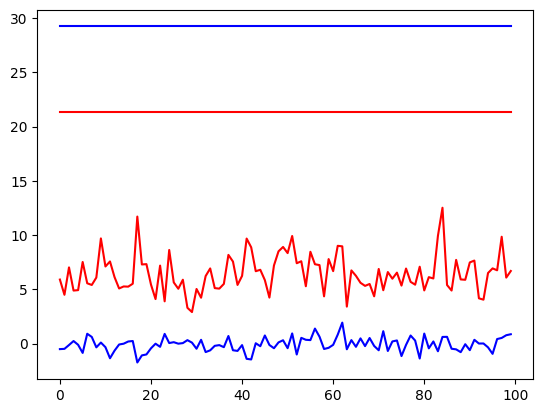

In [81]:
%matplotlib inline
plt.plot(Jstds,'r')
plt.plot(Jmean,'b')
plt.plot([np.std(L1es)]*len(Jstds),'r-')
plt.plot([np.mean(L1es)]*len(Jstds),'b-')

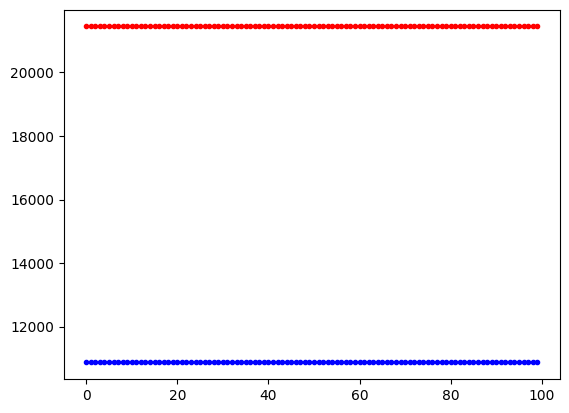

In [82]:
plt.plot([np.std(L2es)]*len(Jstds),'r.')
plt.plot([np.mean(L2es)]*len(Jstds),'b.')

###### 验证 estimate 的效果


- $||A||_F^2=Tr(AA^T) = \frac{1}{m}\sum_i^m v_i AA^T v_i^T$

In [22]:
O = 100
I = 50 
sample_times = 100
A = torch.randn(O,I)
v = torch.randint(2,(100, O))*2-1
v = v.float()
ground_truth = (A**2).sum()
estima_value = torch.einsum('bi,ij,lj,bl->b',v,A,A,v).mean()
estima_value2= torch.sum(torch.einsum('bi,ij->bj',v,A)**2,dim=-1).mean(0)
print(ground_truth)
print(estima_value)
print(estima_value2)

tensor(5052.1685)
tensor(5210.1504)
tensor(5210.1504)


$$
2(||A||_F^2 - \sum_{i}^n A_{ii}^2)=Var(v A v^T) \quad where \quad v\sim 
\{\begin{align}
    &+1 ，50\%\\
    &-1，50\%
\end{align}
$$

sample_times 没必要太大就有比较好的效果

  0%|          | 0/100 [00:00<?, ?it/s]

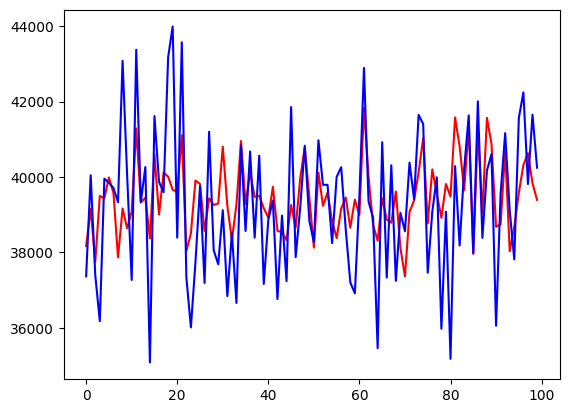

In [480]:
glist=[]
elist=[]
for _ in tqdm(range(100)):
    O = 100
    sample_times = 1000
    A = torch.randn(O,O) 
    A = A+A.transpose(1,0)
    v = torch.randint(2,(sample_times, O))*2-1
    v = v.float()
    ground_truth = 2*((A**2).sum() - (A**2).trace())
    estima_value = torch.einsum('bi,il,bl->b',v,A,v).var()
    glist.append(ground_truth)
    elist.append(estima_value)
plt.plot(glist,'r')
plt.plot(elist,'b')

- $\sum_{i}^n A_{ii}^2 =   ||A||_F^2 - Var(\sum_i^m v_i A v_i^T)/2$

sample_times 需要比较大才有好效果

In [440]:
import pandas as pd
import plotly.express as px

In [7]:
glist=[]
elist=[]
vlist=[]
for _ in tqdm(range(30)):
    O = 100
    sample_times = 1000
    A = torch.randn(O,O) 
    A = A+A.transpose(1,0)
    v = torch.randint(2,(sample_times, O))*2-1
    v = v.float()
    ground_truth = (A**2).sum()
    estima_value = (A**2).trace()
    var = torch.einsum('bi,il,bl->b',v,A,v).var()/2
    vlist.append(var.item())
    glist.append(ground_truth.item())
    elist.append(estima_value.item())

NameError: name 'tqdm' is not defined

In [1]:
# data = []
# xmap ={}
# for i,(v,s,t) in enumerate(zip(vlist,glist,elist)):
#     data.append([r"$ ||A||_F^2 $",s,i+0.24])  
    
#     data.append([r"$Var(v A v^T)/2$",v,i])  
#     data.append([r"$\sum_{i}^n A_{ii}^2$",t,i])  
    
# names_col = ['layer','value', 'block']
# plot_df = pd.DataFrame(data=data,columns=names_col)
# fig = px.bar(plot_df, x='block', y='value', color='layer' ,title='My plot',height=600)
# fig.update_layout(showlegend=True) 
# fig.show()

$\sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma} \rightarrow 0$

In [102]:
B=1
I=10
O=30
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()
shape = y.shape
sample_times=1000
func_model, params =  make_functional(model)

In [82]:
def CorrelationTerm(params,x,cotangents_variable):
    '''
    \sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma}
    '''
    J = vmap(jacrev(func_model, argnums=1), (None, 0))(params, x) #(B, O, I)
    B, O, I =J.shape
    K = torch.ones(I,I) - torch.eye(I,I)
    K = K.to(J.device)
    # L^\gamma = \sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma}
    C = torch.einsum('bij,jk,bik->bi',J,K,J) #(B,O)  L^\gamma
    C = (C**2).sum(-1) #(B) \sum_\gamma (L^\gamma)^2
    return C

In [83]:
def TrvJOJv_and_ETrAAT(params,x,cotangents_variable):
    _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
    vJ   = vJ_fn(cotangents_variable)[0]
    dims = list(range(1,len(vJ.shape)))
    vJO  = vJ.sum(dims,keepdims=True)-vJ # <vJ|1-I|
    vJOJv= (vJ*vJO).sum(dims)#should sum over all dimension except batch
    return vJOJv, functorch.jvp(lambda x:func_model(params,x), (x,), (vJO,))[1].norm()# average the batch_size also

In [84]:
def Normlization_Term_2(params,x,cotangents_variables):
    TrvJOJvs,ETrAATs =  vmap(TrvJOJv_and_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables)
    return ETrAATs.mean() - torch.var(TrvJOJvs,0).mean()

In [96]:
with torch.no_grad():
    ground_truth = CorrelationTerm(params,x,None)[0]
    print(ground_truth)

tensor(7.7047, device='cuda:0')


In [103]:
grad_modifier = Nodal_GradientModifier(1,0)

In [119]:
with torch.no_grad():
    grad_modifier.func_model, params =  make_functional(model)
    cotangents_variables = torch.randint(2,(sample_times,*shape)).cuda()*2-1
    ETrAATs  = vmap(grad_modifier.get_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables)
    cotangents_variables = torch.randint(2,(sample_times,*shape)).cuda()*2-1
    TrvJOJvs = vmap(grad_modifier.get_TrvJOJv, (None, None, 0 ))(params, x,cotangents_variables)

In [110]:
ETrAATs.mean()

tensor(9.4774, device='cuda:0')

###### 验证带上 Jacobian 矩阵之后的估计是否准确

- $||A||_F^2=||J(\mathbf{1}-I)J||_F^2=Tr[J(\mathbf{1}-I)J^T J(\mathbf{1}-I)J^T]=<v|J(\mathbf{1}-I)J^T|J(\mathbf{1}-I)J^T|v^T>$

In [29]:
### estimate
shape = y.shape
sample_times=1000
def get_ETrAAT(params,x,cotangents_variable):
    _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
    vJ   = vJ_fn(cotangents_variable)[0]
    vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
    ETrAAT = functorch.jvp(lambda x:func_model(params,x), (x,), (vJO,))[1] # (B,Ouputdim)
    dims = list(range(1,len(ETrAAT.shape)))
    ETrAAT=torch.sum(ETrAAT**2,dim=dims)
    return ETrAAT
def get_TrvJOJv(params,x,cotangents_variable):
        _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
        vJ   = vJ_fn(cotangents_variable)[0]
        dims = list(range(1,len(vJ.shape)))
        vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
        vJOJv= (vJO*vJ).sum(dim=dims)#should sum over all dimension except batch
        return vJOJv

- $\sum_\gamma A_{\gamma\gamma}^2=||A||_F^2 - Var[Tr_m(A)]/2 \quad where \quad A=J(\mathbf{1}-I)J^T$

In [83]:
B=1
I=10
O=30
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()

func_model, params = make_functional(model)
J = vmap(jacrev(func_model, argnums=1), (None, 0))(params, x) #(B, O, I)
B, O, I =J.shape
K = torch.ones(I,I) - torch.eye(I,I)
K = K.to(J.device)
# L^\gamma = \sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma}
C = torch.einsum('bij,jk,bpk->bip',J,K,J) #(B)  L^\gamma
real_result = (C**2).sum(dim=(-1,-2))
real_diagnol = (C**2)[0].trace()

In [84]:
cotangents_variables = torch.randint(2,(sample_times,*shape)).cuda()*2-1
estimate_result = vmap(get_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables).mean(0)
estimate_TrvJOJv = vmap(get_TrvJOJv, (None, None, 0 ))(params, x,cotangents_variables).var(0)/2

print(real_result)
print(estimate_result)
print(real_result[0]-estimate_TrvJOJv[0])
print(real_diagnol)

tensor([141.5324], device='cuda:0', grad_fn=<SumBackward1>)
tensor([145.3345], device='cuda:0', grad_fn=<MeanBackward1>)
tensor(16.3529, device='cuda:0', grad_fn=<SubBackward0>)
tensor(19.9297, device='cuda:0', grad_fn=<TraceBackward0>)


#### 训练测试

In [ ]:
# from model.afnonet import AFNONet
# model = AFNONet((32,64),2,1,1).cuda()
# func_model, params = make_functional(model)
# x = torch.randn(4,1,32,64).cuda()
# cotangents=torch.ones_like(x)

In [ ]:
# from pytorch_memlab import MemReporter
# reporter = MemReporter()
# reporter.report()

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn.functional as F
import functorch
from functorch import jacrev,jacfwd
from functorch import make_functional, vmap, grad,make_functional_with_buffers
import torch

In [16]:
# from model.afnonet import AFNONet
# model = AFNONet((32,64),2,110,110).cuda()
# func_model, params = make_functional(model)
# x = torch.randn(4,110,32,64).cuda()
# y = torch.randn(4,110,32,64).cuda()
# optimzer= torch.optim.Adam(model.parameters())
# shape = x.shape

In [2]:
###
from model.GradientModifier import *
# class Nodal_GradientModifier:
#     def __init__(self,lambda1=1,lambda2=1,sample_times=10):
#         self.lambda1 = lambda1
#         self.lambda2 = lambda2
#         self.sample_times = sample_times
#         self.cotangents_sum_along_x_dimension = None
#     def Normlization_Term_1(self,params,x):
#         if self.cotangents_sum_along_x_dimension is None or self.cotangents_sum_along_x_dimension.shape!=x.shape:
#             self.cotangents_sum_along_x_dimension = torch.ones_like(x)
#         return ((functorch.jvp(lambda x:self.func_model(params,x), (x,), (self.cotangents_sum_along_x_dimension,))[1]-1)**2).mean()
#     def TrvJOJv_and_ETrAAT(self,params,x,cotangents_variable):
#         _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
#         vJ   = vJ_fn(cotangents_variable)[0]
#         dims = list(range(1,len(vJ.shape)))
#         vJO  = vJ.sum(dims,keepdims=True)-vJ # <vJ|1-I|
#         vJOJv= (vJO*vJ).sum(dim=dims)#should sum over all dimension except batch
#         ETrAAT = functorch.jvp(lambda x:self.func_model(params,x), (x,), (vJO,))[1] # (B,Ouputdim)
#         dims = list(range(1,len(ETrAAT.shape)))
#         ETrAAT=ETrAAT.norm(dim=dims)
#         return vJOJv, ETrAAT# DO NOT average the batch_size also
#     def get_TrvJOJv(self,params,x,cotangents_variable):
#         _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
#         vJ   = vJ_fn(cotangents_variable)[0]
#         dims = list(range(1,len(vJ.shape)))
#         vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
#         vJOJv= (vJO*vJ).sum(dim=dims)#should sum over all dimension except batch
#         return vJOJv
#     def get_ETrAAT(self,params,x,cotangents_variable):
#         _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
#         vJ   = vJ_fn(cotangents_variable)[0]
#         vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
#         ETrAAT = functorch.jvp(lambda x:self.func_model(params,x), (x,), (vJO,))[1] # (B,Ouputdim)
#         dims = list(range(1,len(ETrAAT.shape)))
#         ETrAAT=ETrAAT.norm(dim=dims)
#         return ETrAAT
#     def get_ETrAAT_times(self,params,x,cotangents_variables):
#         return vmap(get_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables).mean()
#     def get_TrvJOJv_times(self,params,x,cotangents_variables):
#         return vmap(self.get_TrvJOJv, (None, None, 0 ))(params, x,cotangents_variables).mean()
#     def Normlization_Term_2(self,params,x,cotangents_variables):
#         while True:
#             TrvJOJvs,ETrAATs =  vmap(self.TrvJOJv_and_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables)
#             # (S,B) # (S,B)
#             CorrelationTerm = ETrAATs.mean(0) - TrvJOJvs.var(0)/2 #(B,)
#             # reject when CorrelationTerm < 0 
#             if torch.all(CorrelationTerm>0):break
#         return CorrelationTerm.mean()
# #     def Normlization_Term_2(self,params,x,cotangents_variable):
# #         '''
# #         \sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma}
# #         '''
# #         J = vmap(jacrev(self.func_model, argnums=1), (None, 0))(params, x) #(B, O, I)
# #         B, O, I =J.shape
# #         K = torch.ones(I,I) - torch.eye(I,I)
# #         K = K.to(J.device)
# #         # L^\gamma = \sum_\beta\sum_{\alpha\neq\beta} J_\alpha^{\gamma}J_\beta^{\gamma}
# #         C = torch.einsum('bij,jk,bik->bi',J,K,J) #(B,O)  L^\gamma
# #         C = (C**2).sum(-1) #(B) \sum_\gamma (L^\gamma)^2
# #         return C.mean()
    
#     def Normlization_Term_2_Full(self,params,x,cotangents_variables):
#         return (((vmap(jacrev(self.func_model, argnums=1), (None, 0))(params, x)**2).sum(-1)-1)**2).mean()   
    
#     def backward(self,model, x, y , return_Normlization_Term_1=False, return_Normlization_Term_2=False):
        
#         self.func_model, params =  make_functional(model)
#         shape = y.shape
#         cotangents_variables = torch.randint(2,(self.sample_times,*shape)).cuda()*2-1
#         with torch.no_grad():
#             if self.lambda1 != 0:
#                 Derivation_Term_1 = jacrev(self.Normlization_Term_1, argnums=0)(params, x)
#             if self.lambda2 != 0:
#                 Derivation_Term_2 = jacrev(self.Normlization_Term_2, argnums=0)(params, x,cotangents_variables)
#         for i, param in enumerate(model.parameters()):
#             delta_p = 0
#             if self.lambda1 != 0:delta_p += self.lambda1*Derivation_Term_1[i]
#             if self.lambda2 != 0:delta_p += self.lambda2*Derivation_Term_2[i]
#             if param.grad is not None:
#                 param.grad.data += delta_p
#             else:
#                 param.grad = delta_p
#         with torch.no_grad():
#             if return_Normlization_Term_1: 
#                 return self.Normlization_Term_1(params, x)
#             if return_Normlization_Term_2:
#                 return self.Normlization_Term_2(params, x,cotangents_variables)

In [2]:
from tqdm.notebook import tqdm

In [12]:
# the position of gradient modifier(before `loss.backward` or after `loss.backward`) does not effect the result
##############################################################################################################
B=20
I=10
O=30
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
    def forward(self,x):
        return self.backbone(x)**2
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()
func_model, params = make_functional(model)
optimizer = torch.optim.SGD(model.parameters(),1)

model.load_state_dict(torch.load('debug/model.weight.pt'))
x = torch.load('debug/input.pt')
y = torch.load('debug/ouput.pt')

#optimizer = SGD_Nodel(model.parameters(),1)
#optimzer= torch.optim.Adam(model.parameters())

accues= []
grad_modifier = Nodal_GradientModifier()
weight_beg = model.backbone.weight.cpu().detach().numpy()
# for _ in tqdm(range(1000)):
optimizer.zero_grad()

loss = F.mse_loss(model(x),y)
loss.backward()
grad_modifier.backward(model,x,y)
gradient = model.backbone.weight.grad.cpu().detach().numpy()

optimizer.step()
#     accues.append(accu.item())
weight_end = model.backbone.weight.cpu().detach().numpy()

In [3]:
from model.GradientModifier import *

In [18]:
# the goal about achieve zero loss is depended on the Batch size and the number of data
##############################################################################################################
%matplotlib inline
from mltool.visualization import *
from tqdm.notebook import tqdm

B=20
I=100
O=300
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
        self.normer   = torch.nn.BatchNorm1d(5)
    def forward(self,x):
        B = x.size(0)
        return self.normer((self.backbone(x)**2).reshape(B,5,-1))
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()
func_model, params, buffer = make_functional_with_buffers(model,disable_autograd_tracking=True)
optimizer = torch.optim.SGD(model.parameters(),0.1)

In [19]:
model.eval()
func_model, params, buffer = make_functional_with_buffers(model)
Normlization_Term_1(params,x)

tensor(1.5730, device='cuda:0', grad_fn=<MeanBackward0>)

In [12]:
Derivation_Term_1 = jacrev(Normlization_Term_1, argnums=0)(params, x)

In [20]:
optimizer.zero_grad()

In [23]:
model.train()
for i, param in enumerate(model.parameters()): 
        if param.grad is not None:
            param.grad.data += Derivation_Term_1[i]
        else:
            param.grad = Derivation_Term_1[i]

In [28]:
for i, param in enumerate(model.parameters()): 
    print(param.grad)

tensor([[-1.2276e-02, -1.0989e-02, -1.3704e-02,  ..., -7.6104e-03,
         -1.4797e-02, -8.5898e-03],
        [ 7.4908e-04, -1.9197e-03, -3.2213e-03,  ...,  1.2170e-03,
         -3.2682e-03,  1.5546e-03],
        [-1.3105e-03, -1.4318e-03, -1.5295e-03,  ..., -1.0034e-03,
         -1.4809e-03, -1.2008e-03],
        ...,
        [-3.0976e-03, -1.0720e-02, -1.5319e-02,  ..., -3.2154e-03,
         -1.3077e-02, -6.3999e-03],
        [-1.5298e-03, -2.2058e-03, -2.3698e-03,  ..., -7.9090e-04,
         -2.3699e-03, -1.4047e-03],
        [ 1.3300e-03,  5.5605e-04,  4.1387e-05,  ...,  1.7032e-03,
          5.6949e-04,  1.2305e-03]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1996, 0.1544, 0.1208, 0.1238, 0.1274], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([0., 0., 0., 0., 0.], device='cuda:0')


In [9]:
def Normlization_Term_1(params, x):
    cotangents_sum_along_x_dimension = torch.ones_like(x)
    values = ((functorch.jvp(lambda x: func_model(params, buffer, x),
              (x,), (cotangents_sum_along_x_dimension,))[1]-1)**2).mean()
    return values

In [36]:
grad_modifier = NGmode_estimate(1,1,100)
grad_modifier.func_model, params = make_functional(model,disable_autograd_tracking=True)
grad_modifier.output_shape       = y.shape[1:]
grad_modifier.Normlization_Term_2(params,x)

tensor(165.4064, device='cuda:0')

  0%|          | 0/100 [00:00<?, ?it/s]

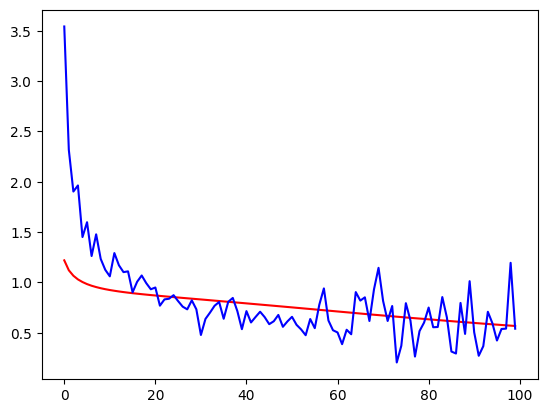

In [37]:
from mltool.visualization import *
from tqdm.notebook import tqdm

B=10
I=10
O=30
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
    def forward(self,x):
        return self.backbone(x)**2
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()

optimizer = torch.optim.SGD(model.parameters(),0.1)
grad_modifier = NGmode_estimate(1,0.01,100)
grad_modifier.func_model, params = make_functional(model)
sample_times = 20
grad_modifier.output_shape = y.shape[1:]

#optimizer = SGD_Nodel(model.parameters(),1)
#optimzer= torch.optim.Adam(model.parameters())

accues1= []
accues2= []

#weight_beg = model.backbone.weight.cpu().detach().numpy()
for _ in tqdm(range(100)):
    optimizer.zero_grad()
    # loss = F.mse_loss(model(x),y)
    # loss.backward()
    #gradient = model.backbone.weight.grad.cpu().detach().numpy()
    grad_modifier.backward(model,x,y)
    accu1,accu2=grad_modifier.inference(model,x,y)
    optimizer.step()
    accues1.append(accu1)
    accues2.append(accu2)
#weight_end = model.backbone.weight.cpu().detach().numpy()
plt.plot(accues1,'r')
plt.plot(accues2,'b')

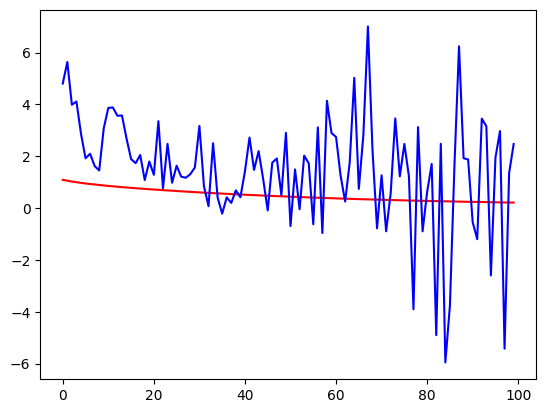

In [20]:
%matplotlib inline


In [77]:
grad_modifier.Normlization_Term_2(params,x)

tensor(0.1821, device='cuda:0', grad_fn=<DivBackward0>)

In [34]:
# the goal about achieve zero loss is depended on the Batch size and the number of data
##############################################################################################################
%matplotlib inline
from mltool.visualization import *
from tqdm.notebook import tqdm
B=20
I=10
O=30
class MyModel(torch.nn.Module):
    def __init__(self, in_chan, out_chan):
        super().__init__()
        self.backbone = torch.nn.Linear(in_chan, out_chan,bias=False)
    def forward(self,x):
        return self.backbone(x)**2
model= MyModel(I, O).cuda()
x    = torch.randn(B, I).cuda()
y    = torch.randn(B, O).cuda()
func_model, params = make_functional(model)
optimizer = torch.optim.SGD(model.parameters(),1)

#optimizer = SGD_Nodel(model.parameters(),1)
#optimzer= torch.optim.Adam(model.parameters())

accues= []
grad_modifier = Nodal_GradientModifier(0,0.001,1000)
#weight_beg = model.backbone.weight.cpu().detach().numpy()
for _ in tqdm(range(10)):
    optimizer.zero_grad()
    # loss = F.mse_loss(model(x),y)
    # loss.backward()
    #gradient = model.backbone.weight.grad.cpu().detach().numpy()
    accu=grad_modifier.backward(model,x,y,return_Normlization_Term_2=True)
    optimizer.step()
    accues.append(accu.item())
#weight_end = model.backbone.weight.cpu().detach().numpy()

plt.plot(accues)

  0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt



In [8]:
import numpy as np

In [52]:
print(np.linalg.norm(weight_end - weight_beg))

1.6432467


In [12]:
print(optimzer.param_groups[0]['params'][0].grad)

In [3]:
cotangents = torch.ones(*shape).cuda()
cotangents_variable  = torch.randint(2,shape).cuda()*2-1
cotangents_variables = torch.randint(2,(10,*shape)).cuda()*2-1

In [4]:
Normlization_Term_1 = lambda params,x:((functorch.jvp(lambda x:func_model(params,x), (x,), (cotangents,)
                                      )[1]-1)**2).mean()
with torch.no_grad():
    Derivation_Term_1 = jacrev(Normlization_Term_1, argnums=0)(params, x)
    torch.cuda.empty_cache()

$$
\sum_\gamma A_{\gamma\gamma}^2=2(||A||_F^2) - Var[Tr_m(A)]=2\{E[Tr_m(AA^T)] - Var[Tr_m(A)]\}
$$
where $A=J(\mathbf{1}-I)J^T$

$$
||A||_F^2= Tr(AA^T)=E[< \vec{v}A|A^T\vec{v}>]
$$

$$
< \vec{v}A| = < \vec{v}J|(\mathbf{1}-I)J^T|= < \vec{u}J^T|=|J\vec{u}>^T
$$

In [5]:
def TrvJOJv_and_ETrAAT(params,x,cotangents_variable):
    _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
    vJ   = vJ_fn(cotangents_variable)[0]
    dims = list(range(1,len(vJ.shape)))
    vJO  = vJ.sum(dims,keepdims=True)-vJ # <vJ|1-I|
    vJOJv= (vJ*vJO).sum(dims)#should sum over all dimension except batch
    return vJOJv, functorch.jvp(lambda x:func_model(params,x), (x,), (vJO,))[1].norm()# average the batch_size also
def get_TrvJOJv(params,x,cotangents_variable):
    _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
    vJ   = vJ_fn(cotangents_variable)[0]
    vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
    vJOJv= (vJ*vJO).sum(-1)#should sum over all dimension except batch
    return vJOJv
def get_ETrAAT(params,x,cotangents_variable):
    _, vJ_fn = functorch.vjp(lambda x:func_model(params,x), x)
    vJ   = vJ_fn(cotangents_variable)[0]
    vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
    return functorch.jvp(lambda x:func_model(params,x), (x,), (vJO,))[1].norm()# average the batch_size also
def get_ETrAAT_times(params,x,cotangents_variables):
    return vmap(get_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables).mean()
def get_TrvJOJv_times(params,x,cotangents_variables):
    return vmap(get_TrvJOJv, (None, None, 0 ))(params, x,cotangents_variables).mean()
def Normlization_Term_2(params,x,cotangents_variables):
    TrvJOJvs,ETrAATs =  vmap(TrvJOJv_and_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables)
    return ETrAATs.mean() - torch.var(TrvJOJvs,0).mean()
def Normlization_Term_2_Full(params,x):
    return (((vmap(jacrev(func_model, argnums=1), (None, 0))(params, x)**2).sum(-1)-1)**2).mean()

In [6]:
with torch.no_grad():
    Derivation_Term_2 = jacrev(Normlization_Term_2, argnums=0)(params, x,cotangents_variables)

In [8]:
params_from_optimizer = optimizer.param_groups[0]['params']

In [14]:
for i,(p1,p2) in enumerate(zip(params_from_optimizer,params)):
    if not torch.allclose(p1,p2):
        print(f"{i:03d}:p1.shape={p1.shape}:p2.shape={p2.shape}")

In [9]:
len(params)

132

In [65]:
# from tqdm.notebook import tqdm
# torch.cuda.empty_cache()
# Derivation_Term_2=[0]*len(params)
# with torch.no_grad():
#     for i in tqdm(range(32)):
#         for j in tqdm(range(64)):
#             small_fun = lambda params,x:func_model(params,x)[:,i,j]
#             Normlization_Term_2= lambda params,x:((
#                 (vmap(jacrev(small_fun, argnums=1), (None, 0))(params, x)**2).sum(-1)-1
#                 )**2).mean()
#             Derivation_Term_2_tuple = jacrev(Normlization_Term_2, argnums=0)(params, x)
#             for k in range(len(Derivation_Term_2_tuple)):
#                 Derivation_Term_2[k]+=Derivation_Term_2_tuple[k]
            

输入 70x32x32 过大, 我们做出近邻假设:
```
                                     (x-h,y-h) (x  ,y-h) (x+h,y-h)
位于 (x,y) 的 pixel 的响应只和他周围 一圈 (x-h,y  ) (x ,y  ) (x+h,y)
                                     (x-h,y+h) (x  ,y+h) (x+h,y+h)
有关
```

###### Define the optimizer

In [ ]:
from collections import defaultdict
import math
from typing import cast, List, Optional, Dict, Tuple

import torch
from torch import Tensor
from .optimizer import Optimizer, _use_grad_for_differentiable

__all__ = ['Adam', 'adam']

class Adam_Nodal(Optimizer):
    def __init__(self, params, lambda1=100,lambda2=100,sample_times=10,lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, *, foreach: Optional[bool] = None,
                 maximize: bool = False, capturable: bool = False,
                 differentiable: bool = False, fused: bool = False):
        assert func_model is not None,"you need provide the function-like model. For example, try `func_model, params = make_functional(model)` "
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        maximize=maximize, foreach=foreach, capturable=capturable,
                        differentiable=differentiable, fused=fused)
        super(Adam, self).__init__(params, defaults)a
        assert len(self.param_groups)==1, "only one group parameter allowed "
        self.params = optimizer.param_groups[0]['params']
        self.func_model = func_model
        if fused:
            if differentiable:
                raise RuntimeError("`fused` cannot be `differentiable`")
            self._step_supports_amp_scaling = True
            # TODO(crcrpar): [low prec params & their higher prec copy]
            # Suppor AMP with FP16/BF16 model params which would need
            # higher prec copy of params to do update math in higher prec to
            # alleviate the loss of information.
            if not all(
                p.is_cuda and torch.is_floating_point(p)
                for pg in self.param_groups for p in pg['params']
            ):
                raise RuntimeError("FusedAdam requires all the params to be CUDA, floating point")
                self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.sample_times = sample_times
        self.cotangents_sum_along_x_dimension = None
        
    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)
            group.setdefault('capturable', False)
            group.setdefault('differentiable', False)
            group.setdefault('fused', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))

                
    def Normlization_Term_1(self,params,x):
        if self.cotangents_sum_along_x_dimension is None or self.cotangents_sum_along_x_dimension.shape!=x.shape:
            self.cotangents_sum_along_x_dimension = torch.ones_like(x)
        return ((functorch.jvp(lambda x:self.func_model(params,x), (x,), (self.cotangents_sum_along_x_dimension,))[1]-1)**2).mean()
    def TrvJOJv_and_ETrAAT(self,params,x,cotangents_variable):
        _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
        vJ   = vJ_fn(cotangents_variable)[0]
        dims = list(range(1,len(vJ.shape)))
        vJO  = vJ.sum(dims,keepdims=True)-vJ # <vJ|1-I|
        vJOJv= (vJ*vJO).sum(dims)#should sum over all dimension except batch
        return vJOJv, functorch.jvp(lambda x:self.func_model(params,x), (x,), (vJO,))[1].norm()# average the batch_size also
    def get_TrvJOJv(self,params,x,cotangents_variable):
        _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
        vJ   = vJ_fn(cotangents_variable)[0]
        vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
        vJOJv= (vJ*vJO).sum(-1)#should sum over all dimension except batch
        return vJOJv
    def get_ETrAAT(self,params,x,cotangents_variable):
        _, vJ_fn = functorch.vjp(lambda x:self.func_model(params,x), x)
        vJ   = vJ_fn(cotangents_variable)[0]
        vJO  = vJ.sum(1,keepdims=True)-vJ # <vJ|1-I|
        return functorch.jvp(lambda x:self.func_model(params,x), (x,), (vJO,))[1].norm()# average the batch_size also
    def get_ETrAAT_times(self,params,x,cotangents_variables):
        return vmap(get_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables).mean()
    def get_TrvJOJv_times(self,params,x,cotangents_variables):
        return vmap(self.get_TrvJOJv, (None, None, 0 ))(params, x,cotangents_variables).mean()
    def Normlization_Term_2(self,params,x,cotangents_variables):
        TrvJOJvs,ETrAATs =  vmap(self.TrvJOJv_and_ETrAAT, (None, None, 0 ))(params, x,cotangents_variables)
        return ETrAATs.mean() - torch.var(TrvJOJvs,0).mean()
    def Normlization_Term_2_Full(model, params,x):
        return (((vmap(jacrev(self.func_model, argnums=1), (None, 0))(params, x)**2).sum(-1)-1)**2).mean()   
    
            
    @_use_grad_for_differentiable
    def step(self, _input,_output, model):
        """Performs a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
            grad_scaler (:class:`torch.cuda.amp.GradScaler`, optional): A GradScaler which is
                supplied from ``grad_scaler.step(optimizer)``.
        """
        self._cuda_graph_capture_health_check()

        # we will firstly update the grad from regularzation term
        # in this case is 
        #     $L1 = \sum_\gamma(\sum_\alpha J_\alpha^{\gamma}-1)^2$
        #     $L2 = \lambda_2[\sum_\gamma A_{\gamma\gamma}^2]$ where $A=J(\mathbf{1}-I)J^T$
        #          for L2 part, we will use Hutchinson Method to estimate the value and do backprogation
        #          $\sum_\gamma A_{\gamma\gamma}^2 = 2\{E[\Tr_m(AA^T)] - Var[\Tr_m(A)]\}$
        
        self.func_model, params =  make_functional(model)
        shape = _output.shape
        cotangents_variables = torch.randint(2,(self.sample_times,*shape)).cuda()*2-1
        with torch.no_grad():
            Derivation_Term_1 = jacrev(self.Normlization_Term_1, argnums=0)(params, _input)
            Derivation_Term_2 = jacrev(self.Normlization_Term_2, argnums=0)(params, _input,cotangents_variables)

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            grad_scale = None
            found_inf = None
            if group['fused'] and grad_scaler is not None:
                grad_scale = grad_scaler._get_scale_async()
                device = grad_scale.device
                grad_scale = _MultiDeviceReplicator(grad_scale)
                found_inf = _get_fp16AMP_params(optimizer=self, grad_scaler=grad_scaler, device=device)

            for p ,d1,d2 in zip(group['params'],Derivation_Term_1,Derivation_Term_2):
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad+d1+d2)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = (
                            torch.zeros((1,), dtype=torch.float, device=p.device)
                            if self.defaults['capturable'] or self.defaults['fused']
                            else torch.tensor(0.)
                        )
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])
                    if group['differentiable'] and state['step'].requires_grad:
                        raise RuntimeError('`requires_grad` is not supported for `step` in differentiable mode')
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'],
                 maximize=group['maximize'],
                 foreach=group['foreach'],
                 capturable=group['capturable'],
                 differentiable=group['differentiable'],
                 fused=group['fused'],
                 grad_scale=grad_scale,
                 found_inf=found_inf)

        return loss



#### 如果我们直接计算出来梯度, 是不是可以减少中间变量的占用

我们接下来要利用的内置函数 vpj, vjp, pjv 实现的是这几个量
- $\sum_\alpha J_\alpha^\gamma$
- $\sum_\alpha H_{\alpha\beta}^\gamma$
- $\sum_\alpha (J_\alpha^\gamma)^2$
- $\sum_\alpha J_\alpha^\gamma H_{\alpha\beta}^\gamma$


##### $\sum_\alpha J_\alpha^\gamma$

In [200]:
jvp_from_batch_J = batch_J.sum(-1)

首先比较 torch 原生的和functorch 的 jvp function

In [195]:
output_pytorch_jvp,jvp_result_pytorch_jvp = torch.autograd.functional.jvp(model, x, torch.ones(7,3))
output_functorch_jvp,jvp_result_functorch_jvp = functorch.jvp(model, (x,), (torch.ones(7,3),))

In [202]:
# result 
print(torch.dist(output_pytorch_jvp,output_functorch_jvp))
print(torch.dist(jvp_result_pytorch_jvp,jvp_result_functorch_jvp))
print(torch.dist(jvp_result_pytorch_jvp,jvp_from_batch_J))

tensor(0., grad_fn=<DistBackward0>)
tensor(0., grad_fn=<DistBackward0>)
tensor(3.4459e-07, grad_fn=<DistBackward0>)


注意到上面的function 没有实现 vmap, 我们现在来尝试用vmap写出

In [206]:
func = lambda x:functorch.jvp(model, (x,), (torch.ones(3),))

In [208]:
output_batch_functorch_jvp,jvp_batch_result_functorch_jvp = vmap(func)(x)

In [211]:
print(torch.dist(output_batch_functorch_jvp,output_pytorch_jvp))
print(torch.dist(jvp_batch_result_functorch_jvp,jvp_from_batch_J))

tensor(4.5825e-07, grad_fn=<DistBackward0>)
tensor(3.3542e-07, grad_fn=<DistBackward0>)


下面进行压力测试

In [222]:
B=200
I=100
O=300
model= MyModel(I, O)
x    = torch.randn(B, I)

In [223]:
%%timeit
output_pytorch_jvp,jvp_result_pytorch_jvp = torch.autograd.functional.jvp(model, x, torch.ones(B,I))

450 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [224]:
%%timeit
output_pytorch_jvp,jvp_result_pytorch_jvp = functorch.jvp(model, (x,), (torch.ones(B,I),))

464 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [226]:
func = lambda x:functorch.jvp(model, (x,), (torch.ones(I),))

In [227]:
%%timeit
output_batch_functorch_jvp,jvp_batch_result_functorch_jvp = vmap(func)(x)

685 µs ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


结论: 不用 vmap 会更加好!

#####  $\sum_\alpha H_{\alpha\beta}^\gamma = \partial_{\beta}\sum_\alpha J^\gamma_{\alpha}$

In [269]:
import torch
from functorch import make_functional, vmap, grad
model= MyModel(3, 4)
x    = torch.randn(7, 3)
func_model, params = make_functional(model)
w    = params[0]
batch_J= vmap(jacrev(func_model, argnums=1), (None, 0))(params, x)
batch_H= jacrev(vmap(jacrev(func_model, argnums=1), (None, 0)), argnums=0)(params, x)

In [270]:
batch_H[0].shape# 后面的 (4,3) 是 weight 的形状, 7 是 batch, 4 是输出的Dim, 3是alpha 

torch.Size([7, 4, 3, 4, 3])

指标 $\beta$ 是指代的第几个 parameter, 也就是 `batch_H` 这个 tuple 里面的第几个量

In [280]:
func = lambda params,x:functorch.jvp(lambda x:func_model(params,x), (x,), (torch.ones(7,3),))[1]
batch_H_sum_from_jvp= jacrev(func, argnums=0)(params, x)
#### full computation
batch_H= jacrev(vmap(jacrev(func_model, argnums=1), (None, 0)), argnums=0)(params, x)
jvp_from_batch_H = batch_H[0].sum(2)
torch.dist(batch_H[0].sum(2),batch_H_sum_from_jvp[0])

tensor(1.2781e-06, grad_fn=<DistBackward0>)

In [ ]:
##### 

In [ ]:
_, vjp_fn = vjp(func_model, x)

ft_jacobian, = vmap(vjp_fn)(unit_vectors)

In [152]:
batch_J= vmap(func, ((None, 0), (None,None)) 
             )( (params, x), (torch.ones(4),torch.ones(3)))

RuntimeError: jvp(f, primals, tangents): Expected primals and tangents to have the same python structure. For example, if primals is a tuple of 3 tensors, tangents also must be. Got primals with structure TreeSpec(tuple, None, [TreeSpec(tuple, None, [*]), *]) and tangents with structure TreeSpec(tuple, None, [*, *])

In [ ]:
_, vjp_fn = vjp(partial(predict, weight, bias), x)

ft_jacobian, = vmap(vjp_fn)(unit_vectors)

In [145]:
from functorch import jvp
x = torch.randn(5)
y = torch.randn(5)
f = lambda x, y: (x * y)
_, output = jvp(f, (x, y), (torch.ones(5), torch.ones(5)))

In [146]:
output

tensor([ 3.1409, -0.3539, -0.2227, -0.5354, -2.3300])

In [ ]:
import math
import torch
from torch import Tensor
from torch.optim import Optimizer
from typing import List, Optional

In [ ]:
def compute_constrained_gradient(grad, hessian)

In [ ]:

class Adam(Optimizer):
    r"""Implements Adam algorithm.

    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False, *, foreach: Optional[bool] = None,
                 maximize: bool = False, capturable: bool = False):
        if not 0.0 <= lr:raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad,
                        maximize=maximize, foreach=foreach, capturable=capturable)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)
            group.setdefault('capturable', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))


    @torch.no_grad()
    def step(self, hessian,closure=None):
        self._cuda_graph_capture_health_check()

        loss = None
        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                            if self.defaults['capturable'] else torch.tensor(0.)
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'],
                 maximize=group['maximize'],
                 foreach=group['foreach'],
                 capturable=group['capturable'])

        return loss



def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[Tensor],
         # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
         # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
         foreach: bool = None,
         capturable: bool = False,
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float,
         maximize: bool):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    if not all([isinstance(t, torch.Tensor) for t in state_steps]):
        raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

    if foreach is None:
        # Placeholder for more complex foreach logic to be added when value is not set
        foreach = False

    if foreach and torch.jit.is_scripting():
        raise RuntimeError('torch.jit.script not supported with foreach optimizers')

    if foreach and not torch.jit.is_scripting():
        func = _multi_tensor_adam
    else:
        func = _single_tensor_adam

    func(params,
         grads,
         exp_avgs,
         exp_avg_sqs,
         max_exp_avg_sqs,
         state_steps,
         amsgrad=amsgrad,
         beta1=beta1,
         beta2=beta2,
         lr=lr,
         weight_decay=weight_decay,
         eps=eps,
         maximize=maximize,
         capturable=capturable)


def _single_tensor_adam(params: List[Tensor],
                        grads: List[Tensor],
                        exp_avgs: List[Tensor],
                        exp_avg_sqs: List[Tensor],
                        max_exp_avg_sqs: List[Tensor],
                        state_steps: List[Tensor],
                        *,
                        amsgrad: bool,
                        beta1: float,
                        beta2: float,
                        lr: float,
                        weight_decay: float,
                        eps: float,
                        maximize: bool,
                        capturable: bool):

    for i, param in enumerate(params):

        grad       = grads[i] if not maximize else -grads[i]
        exp_avg    = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]

        if capturable:
            assert param.is_cuda and step_t.is_cuda, "If capturable=True, params and state_steps must be CUDA tensors."

        # update step
        step_t += 1

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)

        if capturable:
            step = step_t

            # 1 - beta1 ** step can't be captured in a CUDA graph, even if step is a CUDA tensor
            # (incurs "RuntimeError: CUDA error: operation not permitted when stream is capturing")
            bias_correction1 = 1 - torch.pow(beta1, step)
            bias_correction2 = 1 - torch.pow(beta2, step)

            step_size = lr / bias_correction1
            step_size_neg = step_size.neg()

            bias_correction2_sqrt = bias_correction2.sqrt()

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
                # Uses the max. for normalizing running avg. of gradient
                # Folds in (admittedly ugly) 1-elem step_size math here to avoid extra param-set-sized read+write
                # (can't fold it into addcdiv_ below because addcdiv_ requires value is a Number, not a Tensor)
                denom = (max_exp_avg_sqs[i].sqrt() / (bias_correction2_sqrt * step_size_neg)).add_(eps / step_size_neg)
            else:
                denom = (exp_avg_sq.sqrt() / (bias_correction2_sqrt * step_size_neg)).add_(eps / step_size_neg)

            param.addcdiv_(exp_avg, denom)
        else:
            step = step_t.item()

            bias_correction1 = 1 - beta1 ** step
            bias_correction2 = 1 - beta2 ** step

            step_size = lr / bias_correction1

            bias_correction2_sqrt = math.sqrt(bias_correction2)

            if amsgrad:
                # Maintains the maximum of all 2nd moment running avg. till now
                torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
                # Use the max. for normalizing running avg. of gradient
                denom = (max_exp_avg_sqs[i].sqrt() / bias_correction2_sqrt).add_(eps)
            else:
                denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(eps)

            param.addcdiv_(exp_avg, denom, value=-step_size)


def _multi_tensor_adam(params: List[Tensor],
                       grads: List[Tensor],
                       exp_avgs: List[Tensor],
                       exp_avg_sqs: List[Tensor],
                       max_exp_avg_sqs: List[Tensor],
                       state_steps: List[Tensor],
                       *,
                       amsgrad: bool,
                       beta1: float,
                       beta2: float,
                       lr: float,
                       weight_decay: float,
                       eps: float,
                       maximize: bool,
                       capturable: bool):
    if len(params) == 0:
        return

    if capturable:
        assert all(p.is_cuda and step.is_cuda for p, step in zip(params, state_steps)), \
            "If capturable=True, params and state_steps must be CUDA tensors."

    if maximize:
        grads = torch._foreach_neg(tuple(grads))  # type: ignore[assignment]

    # update steps
    torch._foreach_add_(state_steps, 1)

    if weight_decay != 0:
        torch._foreach_add_(grads, params, alpha=weight_decay)

    # Decay the first and second moment running average coefficient
    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)

    torch._foreach_mul_(exp_avg_sqs, beta2)
    torch._foreach_addcmul_(exp_avg_sqs, grads, grads, 1 - beta2)

    if capturable:
        # TODO: use foreach_pow if/when foreach_pow is added
        bias_correction1 = [torch.pow(beta1, step) for step in state_steps]
        bias_correction2 = [torch.pow(beta2, step) for step in state_steps]
        # foreach_sub doesn't allow a scalar as the first arg
        torch._foreach_sub_(bias_correction1, 1)
        torch._foreach_sub_(bias_correction2, 1)
        torch._foreach_neg_(bias_correction1)
        torch._foreach_neg_(bias_correction2)

        # foreach_div doesn't allow a scalar as the first arg
        step_size = torch._foreach_div(bias_correction1, lr)
        torch._foreach_reciprocal_(step_size)
        torch._foreach_neg_(step_size)

        bias_correction2_sqrt = torch._foreach_sqrt(bias_correction2)

        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            max_exp_avg_sqs = torch._foreach_maximum(max_exp_avg_sqs, exp_avg_sqs)  # type: ignore[assignment]

            # Use the max. for normalizing running avg. of gradient
            max_exp_avg_sq_sqrt = torch._foreach_sqrt(max_exp_avg_sqs)
            # Folds in (admittedly ugly) 1-elem step_size math here to avoid extra param-set-sized read+write
            # (can't fold it into addcdiv_ below because addcdiv_ requires value is a Number, not a Tensor)
            torch._foreach_div_(max_exp_avg_sq_sqrt, torch._foreach_mul(bias_correction2_sqrt, step_size))
            eps_over_step_size = torch._foreach_div(step_size, eps)
            torch._foreach_reciprocal_(eps_over_step_size)
            denom = torch._foreach_add(max_exp_avg_sq_sqrt, eps_over_step_size)
        else:
            exp_avg_sq_sqrt = torch._foreach_sqrt(exp_avg_sqs)
            torch._foreach_div_(exp_avg_sq_sqrt, torch._foreach_mul(bias_correction2_sqrt, step_size))
            eps_over_step_size = torch._foreach_div(step_size, eps)
            torch._foreach_reciprocal_(eps_over_step_size)
            denom = torch._foreach_add(exp_avg_sq_sqrt, eps_over_step_size)

        torch._foreach_addcdiv_(params, exp_avgs, denom)
    else:
        bias_correction1 = [1 - beta1 ** step.item() for step in state_steps]
        bias_correction2 = [1 - beta2 ** step.item() for step in state_steps]

        step_size = [(lr / bc) * -1 for bc in bias_correction1]

        bias_correction2_sqrt = [math.sqrt(bc) for bc in bias_correction2]

        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            max_exp_avg_sqs = torch._foreach_maximum(max_exp_avg_sqs, exp_avg_sqs)  # type: ignore[assignment]

            # Use the max. for normalizing running avg. of gradient
            max_exp_avg_sq_sqrt = torch._foreach_sqrt(max_exp_avg_sqs)
            torch._foreach_div_(max_exp_avg_sq_sqrt, bias_correction2_sqrt)
            denom = torch._foreach_add(max_exp_avg_sq_sqrt, eps)
        else:
            exp_avg_sq_sqrt = torch._foreach_sqrt(exp_avg_sqs)
            torch._foreach_div_(exp_avg_sq_sqrt, bias_correction2_sqrt)
            denom = torch._foreach_add(exp_avg_sq_sqrt, eps)

        torch._foreach_addcdiv_(params, exp_avgs, denom, step_size)

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from .architect import Architect
from .history import History


def _concat(xs):
    return torch.cat([x.view(-1) for x in xs])


# TODO: modify to include learnable edge weights.
class ArchitectDARTS(Architect):
    def __init__(self, model, args, writer):
        super(ArchitectDARTS, self).__init__(model, args, writer)

        self.network_momentum = args.train.momentum
        self.network_weight_decay = args.train.weight_decay
        if args.search.gd:
            self.optimizer = torch.optim.SGD(
                self._arch_parameters,
                lr=args.search.arch_learning_rate,
                weight_decay=args.search.arch_weight_decay,
            )
        else:
            self.optimizer = torch.optim.Adam(
                self._arch_parameters,
                lr=args.search.arch_learning_rate,
                betas=(0.5, 0.999),
                weight_decay=args.search.arch_weight_decay,
            )
        self.history = History(
            model, self, to_save=("alphas", "l2_norm", "l2_norm_from_init")
        )
        self.history.dict["grads"] = {}
        for v in ["alphas", "edges"]:
            self.history.dict["grads"][v] = {}
            for ct in self.cell_types:
                self.history.dict["grads"][v][ct] = []

    def initialize_alphas(self):
        k = self.n_edges
        num_ops = self.model._num_ops
        for ct in self.cell_types:
            self.alphas[ct] = Variable(
                1e-3 * torch.randn(k, num_ops).cuda(), requires_grad=True
            )
        self._arch_parameters = [self.alphas[ct] for ct in self.cell_types]

    def initialize_edge_weights(self):
        for ct in self.cell_types:
            self.edges[ct] = Variable(
                torch.ones(self.n_edges).cuda(), requires_grad=False
            )

    def get_alphas(self):
        return {ct: F.softmax(self.alphas[ct], dim=-1) for ct in self.cell_types}

    def get_edge_weights(self):
        return self.edges

    def step(self,input_train,target_train,input_valid, target_valid,eta,network_optimizer,unrolled,**kwargs
    ):
        self.optimizer.zero_grad()
        self.zero_arch_var_grad()
        self.set_model_alphas()
        self.set_model_edge_weights()

        if unrolled:
            self._backward_step_unrolled(
                input_train,
                target_train,
                input_valid,
                target_valid,
                eta,
                network_optimizer,
            )
        else:
            self._backward_step(input_valid, target_valid)
        self.optimizer.step()
        self.steps += 1

    def _backward_step(self, input_valid, target_valid):
        loss = self.model._loss(input_valid, target_valid)
        loss.backward()
        for ct in self.cell_types:
            self.history.dict["grads"]["alphas"][ct].append(
                self.alphas[ct].grad.data.cpu().numpy()
            )

    def _construct_model_from_theta(self, theta):
        model_new = self.model.new()
        model_dict = self.model.state_dict()

        params = {}
        offset = 0
        for k, v in self.model.named_parameters():
            v_length = np.prod(v.size())
            params[k] = theta[offset : offset + v_length].view(v.size())
            offset += v_length

        assert offset == len(theta)
        model_dict.update(params)
        model_new.load_state_dict(model_dict)
        self.initialize_new_model_arch_params(model_new)

        return model_new.cuda()

    def copy_architecture_params(self):
        new_alphas = {
            ct: Variable(self.alphas[ct].data.clone().cuda(), requires_grad=True)
            for ct in self.cell_types
        }
        new_edges = {
            ct: Variable(self.edges[ct].data.clone().cuda(), requires_grad=False)
            for ct in self.cell_types
        }
        return new_alphas, new_edges

    def initialize_new_model_arch_params(self, new_model):
        self._new_alphas, self._new_edges = self.copy_architecture_params()
        alphas = {ct: F.softmax(self._new_alphas[ct], dim=-1) for ct in self.cell_types}
        new_model.set_alphas(alphas)
        new_model.set_edge_weights(self._new_edges)
        new_model.drop_path_prob = self.model.drop_path_prob

    def _compute_unrolled_model(self, input, target, eta, network_optimizer):
        loss = self.model._loss(input, target)
        theta = _concat(self.model.parameters()).data
        try:
            moment = _concat(
                network_optimizer.state[v]["momentum_buffer"]
                for v in self.model.parameters()
            ).mul_(self.network_momentum)
        except:
            moment = torch.zeros_like(theta)
        dtheta = (
            _concat(torch.autograd.grad(loss, self.model.parameters())).data
            + self.network_weight_decay * theta
        )
        self.set_model_alphas()
        self.set_model_edge_weights()
        unrolled_model = self._construct_model_from_theta(
            theta.sub(eta, moment + dtheta)
        )
        return unrolled_model

    def _hessian_vector_product(self, vector, input, target, r=1e-2):
        R = r / _concat(vector).norm()
        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)
        loss = self.model._loss(input, target)
        grads_p = torch.autograd.grad(loss, self._arch_parameters)
        self.set_model_alphas()
        self.set_model_edge_weights()

        for p, v in zip(self.model.parameters(), vector):
            p.data.sub_(2 * R, v)
        loss = self.model._loss(input, target)
        grads_n = torch.autograd.grad(loss, self._arch_parameters)
        self.set_model_alphas()
        self.set_model_edge_weights()

        for p, v in zip(self.model.parameters(), vector):
            p.data.add_(R, v)

        return [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]

    def _backward_step_unrolled(
        self,
        input_train,
        target_train,
        input_valid,
        target_valid,
        eta,
        network_optimizer,
    ):
        unrolled_model = self._compute_unrolled_model(
            input_train, target_train, eta, network_optimizer
        )
        unrolled_loss = unrolled_model._loss(input_valid, target_valid)

        unrolled_loss.backward()
        dalpha = [self._new_alphas[ct].grad for ct in self.cell_types]
        vector = [v.grad.data for v in unrolled_model.parameters()]
        implicit_grads = self._hessian_vector_product(vector, input_train, target_train)

        for g, ig in zip(dalpha, implicit_grads):
            g.data.sub_(eta, ig.data)

        for v, g in zip(self._arch_parameters, dalpha):
            if v.grad is None:
                v.grad = Variable(g.data)
            else:
                v.grad.data.copy_(g.data)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [12]:
def pow_reducer(x):
    return x.pow(3).sum()
inputs = torch.rand(2, 2)
torch.autograd.functional.hessian(pow_reducer, inputs)

tensor([[[[4.8910, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.8857],
          [0.0000, 0.0000]]],


        [[[0.0000, 0.0000],
          [5.9064, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.4972]]]])